# Export bluesky data to CSV

Export bluesky experiment data from databroker to CSV files.  Each data stream is written to its own file.

As a bonus, it is shown how to write all of a run's data to a single JSON file.

First, identify the experiment data to be exported.  Show what catalogs are available.

In [1]:
import databroker
list(databroker.catalog)

['class_2021_03', 'class_example_data']

Pick from the `class_example_data` catalog.

In [2]:
cat = databroker.catalog["class_example_data"]
len(cat)

59

Just show a few of the most recent runs.

In [3]:
from apstools.utils import *
listruns(num=9)

catalog: class_example_data
   scan_id                 time plan_name   detectors
0       90  2021-03-06 14:16:41      scan     [noisy]
1       89  2021-03-06 14:15:35      scan     [noisy]
2       88  2021-03-06 14:14:45      scan     [noisy]
3       87  2021-03-06 14:13:44      scan     [noisy]
4       86  2021-03-06 14:10:46  rel_scan     [noisy]
5       85  2021-03-06 14:10:43  rel_scan     [noisy]
6       84  2021-03-06 14:10:37  rel_scan     [noisy]
7       83  2021-03-06 14:10:19  rel_scan     [noisy]
8       82  2021-03-03 10:01:32     count  [adsimdet]


Check what is in #85.

In [4]:
run = cat[85]
run

BlueskyRun
  uid='b4e4cbbb-a4b1-4146-aea5-ba8bc7ad7b76'
  exit_status='success'
  2021-03-06 14:10:43.261 -- 2021-03-06 14:10:46.260
  Streams:
    * primary
    * baseline


Look at the data in the `primary` stream.  That's the experiment data.

In [5]:
ds = run.primary.read()
ds

<xarray.Dataset>
Dimensions:           (time: 23)
Coordinates:
  * time              (time) float64 1.615e+09 1.615e+09 ... 1.615e+09 1.615e+09
Data variables:
    m1                (time) float64 0.915 0.918 0.922 ... 0.988 0.992 0.995
    m1_user_setpoint  (time) float64 0.9146 0.9183 0.922 ... 0.988 0.9917 0.9954
    noisy             (time) float64 1.464e+03 1.767e+03 ... 1.674e+03 1.494e+03

Plot it.

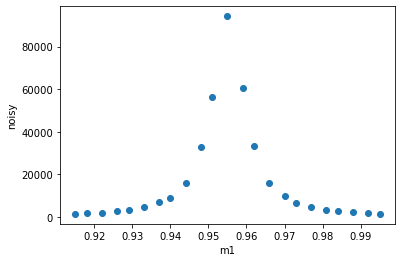

In [6]:
ds.plot.scatter("m1", "noisy")

Assuming #90 has the same type of scan, plot it.

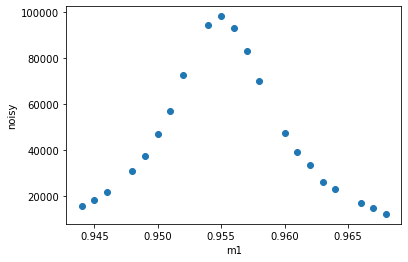

In [7]:
cat[90].primary.read().plot.scatter("m1", "noisy")

## Export one run to CSV

Make a function to do this, then call it with the `run`.  The function should export all data streams and the run's metadata.  Each to a separate CSV file.

1. Starting with a catalog instance, `cat`, pick a `run` by `scan_id` (or `uid`).
2. Look at the stream names, the run's experimental data is in the `primary` stream.
3. The stream data is obtained in an xarray Dataset: `ds = run.primary.read()`
4. The stream data can be converted to CSV (by first converting to a pandas DataFrame): `ds.to_pandas().to_csv()`
5. Write the CSV to a file.
6. The run's metadata is already a dictionary (making it difficult to render as CSV).  The `csv` package has a special writer for dictionaries.

In [8]:
import csv
from xarray.core.dataset import Dataset as xarray_Dataset
from pandas import DataFrame as pandas_DataFrame

def export_run(run):
    "Save all the run information to text files."
    scan_id = run.metadata["start"]["scan_id"]

    def export_data(data, scan_id, label, prefix="run"):
        with open(f"{prefix}-{scan_id}-{label}.csv", "w", newline="\n") as f:
            if isinstance(data, dict):
                writer = csv.DictWriter(f, data.keys())
                writer.writeheader()
                writer.writerow(data)
            elif isinstance(data, xarray_Dataset):
                f.write(data.to_pandas().to_csv())
            elif isinstance(data, pandas_DataFrame):
                f.write(data.to_csv())
            print(f"wrote file: {f.name}")

    export_data(run.metadata, scan_id, "metadata")
    for stream_name in run:
        ds = getattr(run, stream_name).read()
        if stream_name == "baseline":
            ds = ds.to_pandas().transpose()
        export_data(ds, scan_id, stream_name)

export_run(run)

wrote file: run-85-metadata.csv
wrote file: run-85-primary.csv
wrote file: run-85-baseline.csv


## Search for runs by time

Since a search by scan_id` might not be unique, we hope to resolve that by restricting the time span for a search.  Here's how to search by a time span.

In [9]:
time_span = databroker.queries.TimeRange(since="2021-03-06 14:00", until="2021-03-06 16:00")
runs = cat.search(time_span)
len(cat), len(runs)

(59, 8)

## Export a list of runs

Search the catalog by time and `scan_id` for a **_list_** of runs.  Call the `export_run()` function on each run.  We'll look for #70 - #84 using the `range(70, 86)` function.  But, since we have a time restriction, only some of the scans will be written.

The result of `cat.search(query)` (where `query` is a dictionary of search terms) is another catalog with runs matching the search terms.  This result can be searched again and again as needed.  The dictionary can use [mongoquery](https://docs.mongodb.com/manual/reference/operator/query/) as shown here: `{'scan_id': {'$in': scan_id_list}}`

Here, a time span is selected along with a list of scan IDs.  The time span is searched first, since any `scan_id` might not be unique in the catalog.  (_assumption_: A `scan_id` might be unique within the time span.)  The result is a catalog of scans from the list but also within the time span.

In [10]:
def export_runs(scan_id_list, since=None, until=None):
    runs = cat
    # first by date since scan_id might not be unique for all times
    if since is not None:
        runs = runs.search(databroker.queries.TimeRange(since=since))
    if until is not None:
        runs = runs.search(databroker.queries.TimeRange(until=until))
    # now, search by scan_id (in the supplied list)
    runs = runs.search({'scan_id': {'$in': scan_id_list}})

    for uid in runs:
        export_run(runs[uid])

export_runs(range(70, 86), since="2021-03-06 14:00")

wrote file: run-83-metadata.csv
wrote file: run-83-primary.csv
wrote file: run-83-baseline.csv
wrote file: run-84-metadata.csv
wrote file: run-84-primary.csv
wrote file: run-84-baseline.csv
wrote file: run-85-metadata.csv
wrote file: run-85-primary.csv
wrote file: run-85-baseline.csv


## Export run to JSON file

A Python dictionary can be written to JSON (its contents can be expressed in JSON.  There are a few notable problems, such as `None` values.)  Here, a dictionary (`data`) is built with the different parts of a run (metadata, streams).  Then `data` is written to a single file.

In [12]:
import json

def export_json(run):
    """Export all data from a run to a JSON file."""
    scan_id = run.metadata["start"]["scan_id"]
    data = {"metadata": run.metadata}
    for stream_name in list(run):  # get ALL the streams
        # such as data["primary"] = run.primary.read().to_dict()
        data[stream_name] = getattr(run, stream_name).read().to_dict()
    with open(f"run_{scan_id}.json", "w", newline="\n") as f:
        f.write(json.dumps(data, indent=2))
        print(f"wrote file {f.name}")

export_json(run)


wrote file run_85.json
